In [1]:
#human,centaur-7b,centaur-80b,llama-8b,llama-reason,rw,some other
colors=['#000000','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#CC79A7','#D55E00']


### Import

In [2]:
import glob
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random

In [3]:
os.getcwd()
PATH=os.getcwd()+'/data/out'

In [4]:
plt.rcParams.update({
    'font.size': 18,        # everything (titles, labels, ticks, legend) gets bigger
    'axes.titlesize': 26,   # override just titles if you want
    'axes.labelsize': 22,   # axis labels
    'xtick.labelsize': 22,  # x-tick labels
    'ytick.labelsize': 22,  # y-tick labels
    'legend.fontsize': 18   # legend text
})

### Rescorla

In [5]:
rw_df=pd.read_csv(f'{PATH}/rw/rw_reversal_learning.csv')

In [6]:
def bandit_1_prop(df,choice):
  df_copy=df.copy()
  df_copy['bandit1_chosen'] = (df_copy['choice'] == choice).astype(int)
  df_copy['bandit_1_avg']=df_copy.groupby("model_id")["bandit1_chosen"].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
  return df_copy

In [7]:
rw_df=bandit_1_prop(rw_df,0)

In [8]:
def plot_bandit_1_avg(df, trial_col="trial_num", bandit_avg_col="bandit_1_avg",label=None):
    """
    Plots the average choice rate of bandit 1 over trials with standard error shading.

    Parameters:
    - df: DataFrame containing trial data.
    - trial_col: Column name representing trial numbers (default: "trial").
    - bandit_avg_col: Column name representing average bandit 1 choice rate (default: "bandit_1_avg").
    """

    # Group by trial and calculate mean and standard error
    grouped = df.groupby(trial_col)[bandit_avg_col]
    mean_bandit_1_avg = grouped.mean()
    std_error = grouped.std() / np.sqrt(grouped.count())  # SE = std / sqrt(N)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(mean_bandit_1_avg.index, mean_bandit_1_avg.values, label='Mean bandit_1_avg', color='blue')

    # Add shaded area for standard error
    plt.fill_between(
        mean_bandit_1_avg.index,
        mean_bandit_1_avg - std_error,
        mean_bandit_1_avg + std_error,
        color='blue',
        alpha=0.3,  # Transparency for standard error region
        label='Standard Error'
    )

    # Add a reference line for chance level (0.5)
    plt.axhline(y=0.5, color="r", linestyle="--", label="Chance Level (0.5)")

    # Labels and title
    plt.xlabel('Trial')
    plt.ylabel('Average bandit_1_avg')
    plt.title('Average bandit_1_avg over Trials with Standard Error')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()


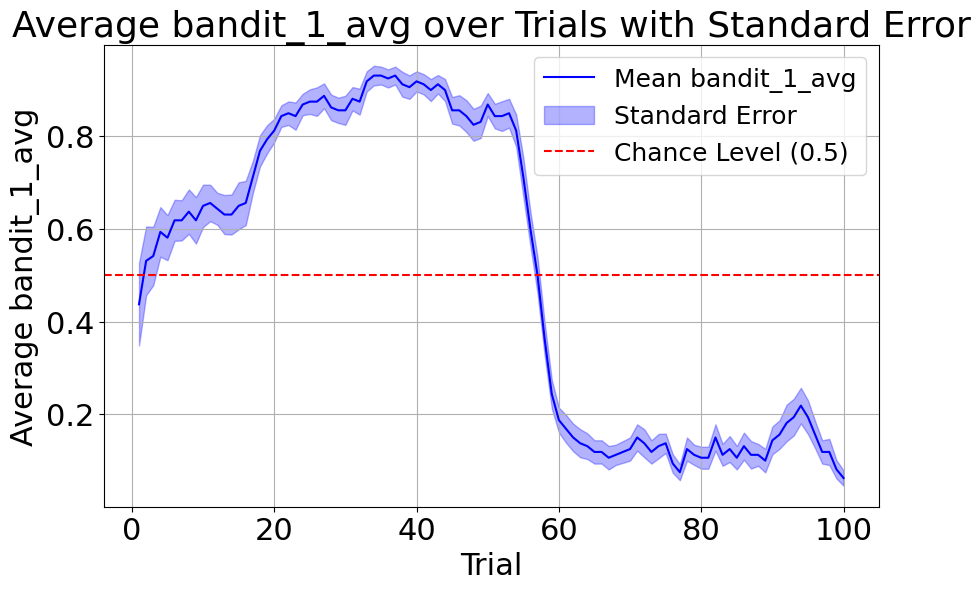

In [9]:
plot_bandit_1_avg(rw_df,trial_col="trial", bandit_avg_col="bandit_1_avg", label='Bandit 1 Average')

### centaur

In [10]:
def read_data_from_folder(folder_path):
    dfs = pd.DataFrame()
    file_count = 0  # counter for loaded files

    # Regex to extract the number after "participant_" and before ".csv"
    # This regex looks for "participant_" followed by one or more digits (\d+)
    # and captures these digits. It expects ".csv" at the end.
    participant_id_regex = re.compile(r'participant_(\d+)\.csv')


    for filename in os.listdir(folder_path):
        if filename.endswith('.csv'):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_csv(file_path)

            # Extract model_id from filename using regex
            match = participant_id_regex.search(filename)
            if match:
                model_id = int(match.group(1)) # Convert the captured digits to an integer
                df['model_id'] = model_id # Add the model_id column
            else:
                # Handle cases where the filename doesn't match the expected format
                print(f"Warning: Could not extract model_id from filename: {filename}")
                df['model_id'] = None # Or some other indicator of missing ID

            dfs = pd.concat([dfs, df], ignore_index=True)
            file_count += 1  # increment counter

    print(f"{file_count} CSV file(s) loaded.")
    return dfs

In [11]:
df_centaur=read_data_from_folder(f'{PATH}/centaur-8B/singles')

32 CSV file(s) loaded.


In [12]:
df_centaur=bandit_1_prop(df_centaur,'U')

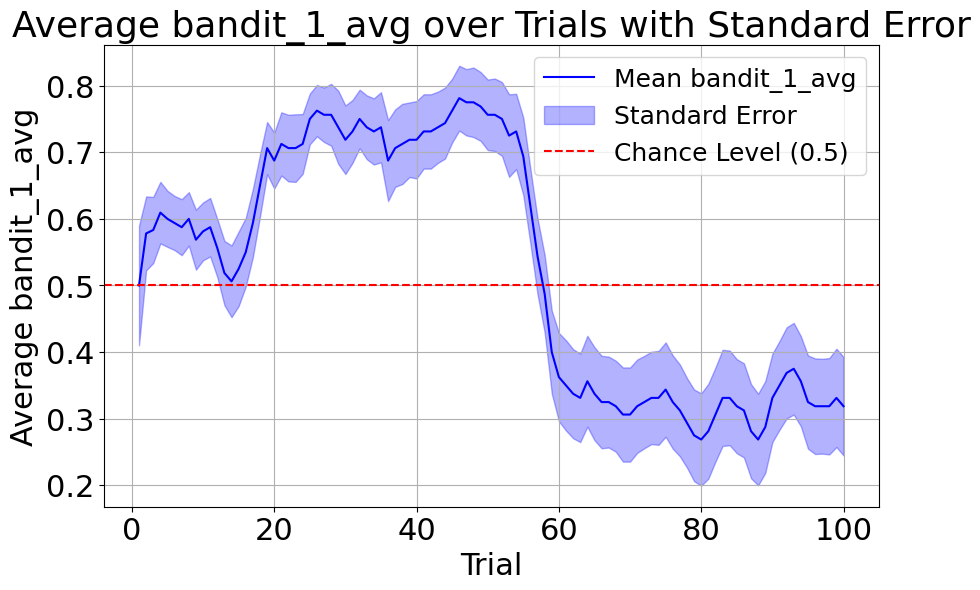

In [13]:
plot_bandit_1_avg(df_centaur, trial_col="trial_num", bandit_avg_col="bandit_1_avg", label='Centaur-8B')

### repetetive

In [14]:
df_rep=pd.read_csv(f'{PATH}/repetetive/repetetive_randomized.csv')

In [15]:
df_rep=bandit_1_prop(df_rep,'bandit_1')

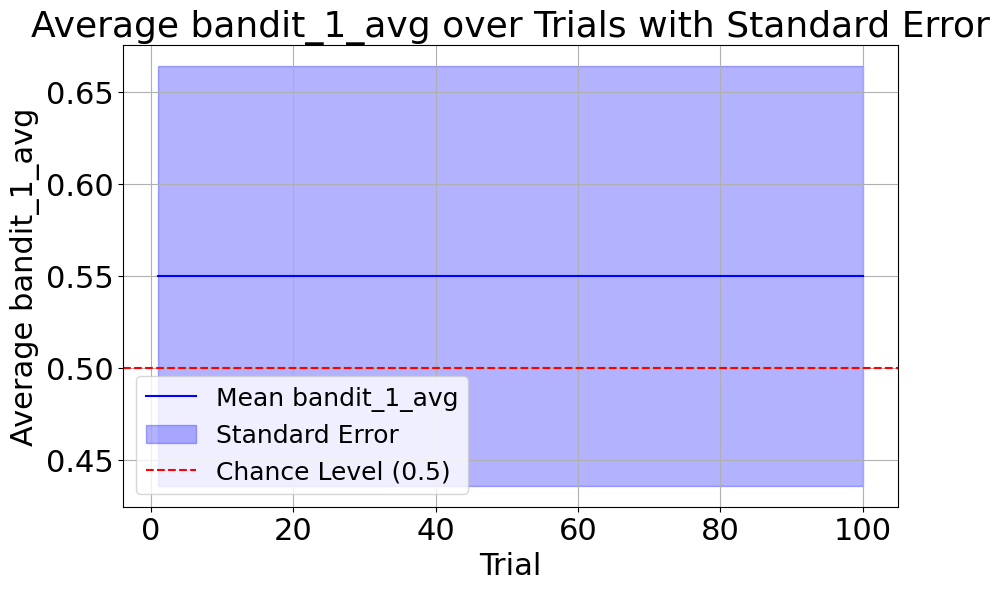

In [16]:
plot_bandit_1_avg(df_rep,trial_col="trial")

### timeline

In [17]:
random.seed(42)

# Number of trials
num_trials = 100

# Define the timeline
timeline = []
for i in range(num_trials):
    while True:
        if i < (num_trials / 2):
            bandit_1_reward = random.choices([1, 0], weights=[0.8, 0.2])[0]
            bandit_2_reward = random.choices([1, 0], weights=[0.2, 0.8])[0]
        else:
            bandit_1_reward = random.choices([1, 0], weights=[0.2, 0.8])[0]
            bandit_2_reward = random.choices([1, 0], weights=[0.8, 0.2])[0]

        if not (bandit_1_reward == 0 and bandit_2_reward == 0):
            break

    timeline.append({
        "bandit_1": {"color": "orange", "value": bandit_1_reward},
        "bandit_2": {"color": "blue", "value": bandit_2_reward}
    })

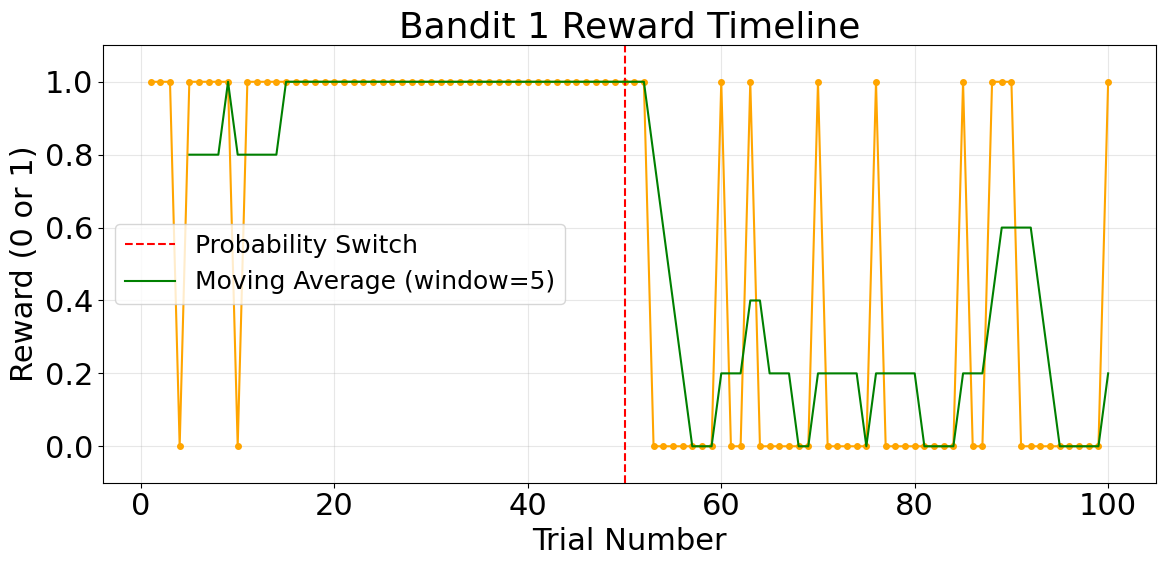

In [18]:
# Extract bandit 1 rewards
bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(range(1, num_trials + 1), bandit_1_rewards, color='orange', marker='o', linestyle='-', markersize=4)

# Add a vertical line at the probability switch point
plt.axvline(x=num_trials/2, color='red', linestyle='--', label='Probability Switch')

# Calculate and plot the moving average (window size = 10)
window_size = 5
moving_avg = np.convolve(bandit_1_rewards, np.ones(window_size)/window_size, mode='valid')
plt.plot(range(window_size, num_trials + 1), moving_avg, color='green', linestyle='-', label='Moving Average (window=5)')

# Customize the plot
plt.title('Bandit 1 Reward Timeline')
plt.xlabel('Trial Number')
plt.ylabel('Reward (0 or 1)')
plt.ylim(-0.1, 1.1)  # Set y-axis limits
plt.grid(True, alpha=0.3)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

### Bandit Choice Trends Function

In [19]:
def plot_bandit_choice_trends(human_df=None,df_rep=None, dfs=None, labels=None, colors=None, trial_col="trial_num",
                               bandit_avg_col="bandit_1_avg", reversal_trials=[14, 50],
                              timeline=None,legend_anchor=(0.5, 0.5),
                               xlim=(0, 100), title="Generative performance",
                               margins=True):
    """
    Plots bandit 1 choice trends with multiple reversal points and overlays model predictions.

    Args:
        human_df (pd.DataFrame): Human data with trial-wise bandit choice.
        dfs (list of pd.DataFrame): Model prediction DataFrames.
        labels (list of str): Labels for models.
        colors (list of str): Colors for plotting (first is for human).
        trial_col (str): Trial number column.
        bandit_avg_col (str): Column for P(choose bandit 1).
        reversal_trials (list of int): List of reversal trial indices.
        xlim (tuple): Trial range to plot.
        title (str): Title for the plot.
        margins (bool): Whether to plot confidence intervals.
    """
    fig, (ax_prob, ax_main) = plt.subplots(
        2, 1, figsize=(12, 10),
        gridspec_kw={'height_ratios': [1, 4]},
        sharex=True
    )

    # --- Reward Probability Transition Plot ---
    for reversal in reversal_trials:
        # Purple bandit
        ax_prob.plot([1, reversal - 2], [0.8, 0.8], 'purple', linewidth=3)
        ax_prob.plot([reversal + 2, xlim[1]], [0.2, 0.2], 'purple', linewidth=3)
        ax_prob.plot([reversal - 2, reversal + 2], [0.8, 0.2], 'purple', linewidth=3)

        # Blue bandit
        ax_prob.plot([1, reversal - 2], [0.2, 0.2], 'blue', linewidth=3)
        ax_prob.plot([reversal + 2, xlim[1]], [0.8, 0.8], 'blue', linewidth=3)
        ax_prob.plot([reversal - 2, reversal + 2], [0.2, 0.8], 'blue', linewidth=3)

    #ax_prob.set_ylabel('Reward Probability\n (Bandit 1)')
    ax_prob.set_ylim(0, 1)
    ax_prob.set_xlim(xlim)
    ax_prob.set_yticks([0.2, 0.8])
    ax_prob.set_yticklabels(['20%', '80%'])
    ax_prob.spines['top'].set_visible(False)
    ax_prob.spines['right'].set_visible(False)
    ax_prob.set_title("Reward Probability Transition")

    # --- Human data ---
    if human_df is not None:
      grouped = human_df.groupby(trial_col)[bandit_avg_col]
      mean_human = grouped.mean()
      std_human = grouped.std() / np.sqrt(grouped.count())
      human_color = colors[0]

      ax_main.plot(mean_human.index, mean_human.values, color=human_color,
                  linewidth=0.5, label='Human', alpha=1, zorder=1)
      if margins:
          ax_main.fill_between(mean_human.index, mean_human - std_human,
                              mean_human + std_human, color=human_color,
                              alpha=0.2, zorder=1)
    if df_rep is not None:
      grouped = df_rep.groupby(trial_col)[bandit_avg_col]
      mean_human = grouped.mean()
      std_human = grouped.std() / np.sqrt(grouped.count())
      human_color = colors[-1]

      ax_main.plot(mean_human.index, mean_human.values, color=human_color,
                  linewidth=1.5, label=labels[-1], alpha=1, zorder=1)
      if margins:
          ax_main.fill_between(mean_human.index, mean_human - std_human,
                              mean_human + std_human, color=human_color,
                              alpha=0.3, zorder=1)


    # --- Model Data ---
    if dfs is not None and labels is not None and colors is not None: # Add None check
        # Use colors from index 1 onwards for models, assuming colors[0] is for human
        model_colors = colors[1:]
        for i, (df, label) in enumerate(zip(dfs, labels)):
            grouped = df.groupby(trial_col)[bandit_avg_col]
            mean_model = grouped.mean()
            sem_model = grouped.std() / np.sqrt(grouped.count())

            # Ensure color index is within bounds of model_colors
            model_color = model_colors[i % len(model_colors)] if model_colors else None


            ax_main.plot(mean_model.index, mean_model.values, label=label,
                         color=model_color, linestyle='-', linewidth=1.5, alpha=1, zorder=3)
            if margins:
                ax_main.fill_between(mean_model.index, mean_model - sem_model,
                                     mean_model + sem_model, color=model_color,
                                     alpha=0.4, zorder=3)

    # --- Reversal Lines ---
    for reversal in reversal_trials:
        ax_main.axvline(x=reversal, color='black', linestyle='--', linewidth=1.0,
                        alpha=0.3, zorder=0, label=f'Reversal (Trial {reversal})')
    #--- Reward Ground Truth
    if timeline is not None: # Add None check
        # Need to determine the length of the timeline for x-axis
        num_trials_timeline = len(timeline) if timeline else 0
        if num_trials_timeline > 0:
            bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]
            ax_main.plot(range(1, num_trials_timeline + 1), bandit_1_rewards, color='gray', marker='|',
                        linestyle='', markersize=10, alpha=0.6, label='Ground Truth Rewards')


    ax_main.set_xlabel("Trial Number")
    ax_main.set_ylabel("Bandit 1 Choice Rate")
    #ax_main.set_title(f"{title}")
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(-0.05, 1.05)
    #ax_main.legend()
    ax_main.grid(False)
    # Save handles and labels for external legend
    handles, labels_legend = ax_main.get_legend_handles_labels()
    legend_fig = plt.figure(figsize=(6, 2))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis("off")
    legend = legend_ax.legend(handles, labels_legend, loc='center', frameon=False)
    ax_main.margins(x=0.04)

    plt.tight_layout()
    # plt.show() # Remove plt.show() here
    return fig, legend_fig

In [20]:
def plot_bandit_choice_trends_single_axis(human_df=None, df_rep=None, dfs=None, labels=None, colors=None,
                                          trial_col="trial_num", bandit_avg_col="bandit_1_avg",
                                          reversal_trials=[14, 50], timeline=None,
                                          xlim=(0, 100), margins=True, legend_anchor=(0.5, 0.5)):
    """
    Plots bandit 1 choice trends (no reward probability subplot). Overlays human and model predictions.

    Args:
        human_df (pd.DataFrame): Human data with trial-wise bandit choice.
        df_rep (pd.DataFrame): Repetitive baseline model.
        dfs (list of pd.DataFrame): Model prediction DataFrames.
        labels (list of str): Labels for models.
        colors (list of str): Colors for plotting (first is for human).
        trial_col (str): Trial number column.
        bandit_avg_col (str): Column for P(choose bandit 1).
        reversal_trials (list of int): List of reversal trial indices.
        timeline (list of dict): Optional reward schedule for reference markers.
        xlim (tuple): Trial range to plot.
        margins (bool): Whether to plot confidence intervals.
        legend_anchor (tuple): Anchor position for external legend.
    """
    fig, ax = plt.subplots(figsize=(12, 10))

    # --- Human Data ---
    if human_df is not None:
        grouped = human_df.groupby(trial_col)[bandit_avg_col]
        mean = grouped.mean()
        sem = grouped.std() / np.sqrt(grouped.count())
        human_color = colors[0]

        ax.plot(mean.index, mean.values, color=human_color, linewidth=0.5, label='Human', alpha=1)
        if margins:
            ax.fill_between(mean.index, mean - sem, mean + sem, color=human_color, alpha=0.2)

    # --- Repetitive Baseline ---
    if df_rep is not None:
        grouped = df_rep.groupby(trial_col)[bandit_avg_col]
        mean = grouped.mean()
        sem = grouped.std() / np.sqrt(grouped.count())
        rep_color = colors[-1]

        ax.plot(mean.index, mean.values, color=rep_color, linewidth=1.5, label=labels[-1], alpha=1)
        if margins:
            ax.fill_between(mean.index, mean - sem, mean + sem, color=rep_color, alpha=0.3)

    # --- Model Data ---
    if dfs is not None and labels is not None and colors is not None:
        model_colors = colors[1:]  # skip human
        for i, (df, label) in enumerate(zip(dfs, labels)):
            grouped = df.groupby(trial_col)[bandit_avg_col]
            mean = grouped.mean()
            sem = grouped.std() / np.sqrt(grouped.count())
            model_color = model_colors[i % len(model_colors)]

            ax.plot(mean.index, mean.values, label=label, color=model_color, linewidth=1.5, alpha=1)
            if margins:
                ax.fill_between(mean.index, mean - sem, mean + sem, color=model_color, alpha=0.4)

    # --- Reversal Markers ---
    for reversal in reversal_trials:
        ax.axvline(x=reversal, color='black', linestyle='--', linewidth=1.0, alpha=0.3)

    # --- Optional Ground Truth Rewards ---
    if timeline is not None:
        bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]
        ax.plot(range(1, len(bandit_1_rewards)+1), bandit_1_rewards,
                color='gray', marker='|', linestyle='', markersize=10, alpha=0.6,
                label='Ground Truth Rewards')

    # --- Formatting ---
    ax.set_xlabel("Trial Number")
    ax.set_ylabel("Bandit 1 Choice Rate")
    ax.set_xlim(xlim)
    ax.set_ylim(-0.05, 1.05)
    ax.grid(False)
    ax.margins(x=0.04)

    # --- Legend saved separately ---
    handles, labels_legend = ax.get_legend_handles_labels()
    legend_fig = plt.figure(figsize=(6, 2))
    legend_ax = legend_fig.add_subplot(111)
    legend_ax.axis("off")
    legend_ax.legend(handles, labels_legend, loc='center', frameon=False)

    plt.tight_layout()
    return fig, legend_fig


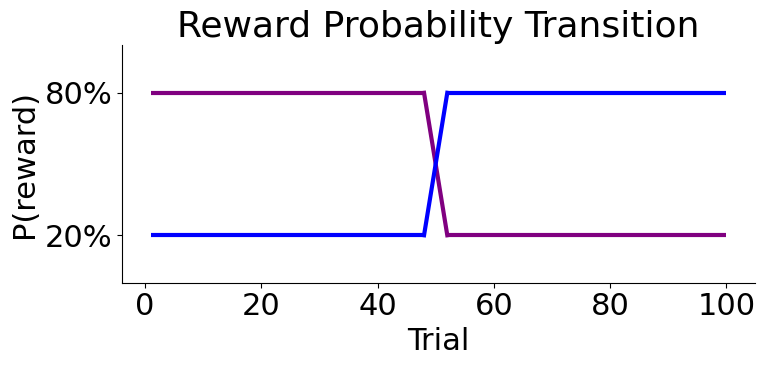

In [21]:
# Define where the reward probabilities reverse
reversal_trial = 50

# Create a figure and axis
fig, ax_prob = plt.subplots(figsize=(8, 4))

# --- Probability Transition Plot ---
# First option (e.g., orange)
ax_prob.plot([1, reversal_trial-2], [0.8, 0.8], 'purple', linewidth=3, solid_capstyle='butt')
ax_prob.plot([reversal_trial+2, 100], [0.2, 0.2], 'purple', linewidth=3, solid_capstyle='butt')
ax_prob.plot([reversal_trial-2, reversal_trial+2], [0.8, 0.2], 'purple', linewidth=3)

# Second option (e.g., blue)
ax_prob.plot([1, reversal_trial-2], [0.2, 0.2], 'blue', linewidth=3, solid_capstyle='butt')
ax_prob.plot([reversal_trial+2, 100], [0.8, 0.8], 'blue', linewidth=3, solid_capstyle='butt')
ax_prob.plot([reversal_trial-2, reversal_trial+2], [0.2, 0.8], 'blue', linewidth=3)

# Formatting
ax_prob.set_ylabel('P(reward)')
ax_prob.set_ylim(0, 1)
ax_prob.set_yticks([0.2, 0.8])
ax_prob.set_yticklabels(['20%', '80%'])
ax_prob.spines['top'].set_visible(False)
ax_prob.spines['right'].set_visible(False)

plt.xlabel('Trial')
plt.title('Reward Probability Transition')
plt.tight_layout()
plt.show()


### centaur-70b

In [22]:
df_centaur_70b=read_data_from_folder(f'{PATH}\centaur-70B\singles')

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\snamazova\AppData\Local\Temp\ipykernel_22136\266042738.py:1: SyntaxWarning: invalid escape sequence '\c'
  df_centaur_70b=read_data_from_folder(f'{PATH}\centaur-70B\singles')


32 CSV file(s) loaded.


In [23]:
df_centaur_70b=bandit_1_prop(df_centaur_70b,'U')

In [24]:
#human,centaur-7b,centaur-80b,llama-8b,llama-reason,rw,some other
colors_centaur = ['black','#d65db1', '#845ec2', '#F3AEB8', '#EE7E8D','#CAC8E0']

In [25]:
#human,centaur-7b,centaur-80b,llama-8b,llama-reason,rw,some other
colors_grouped= ['#44403B','#E69F00', '#D55E00', '#56B4E9', '#0072B2','#CC79A7','#009E73']


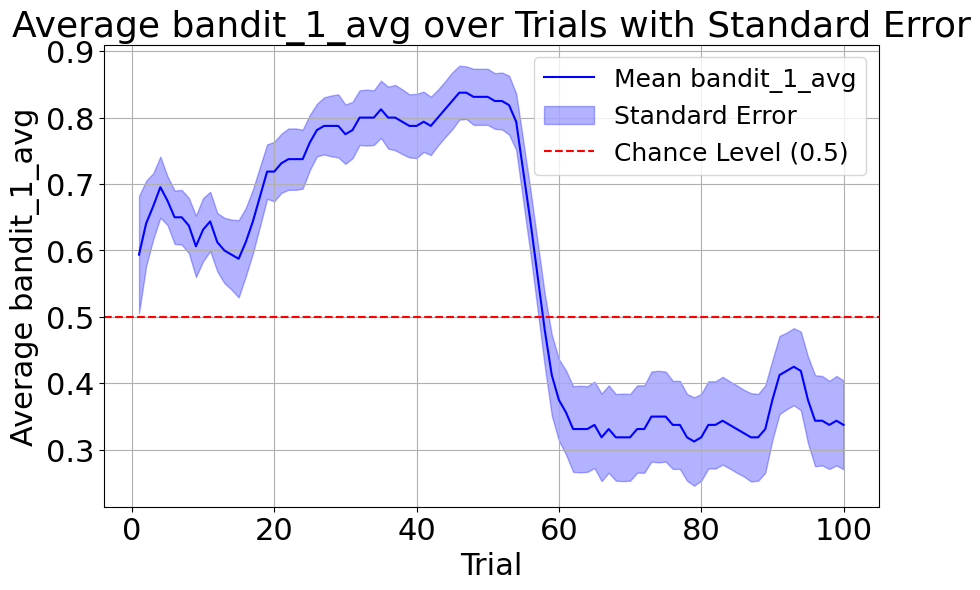

In [26]:
plot_bandit_1_avg(df_centaur_70b, trial_col="trial_num", bandit_avg_col="bandit_1_avg", label='Centaur-70B')

### Llama-8b

In [27]:
df_llama=read_data_from_folder(f'{PATH}/llama-8b/singles')

32 CSV file(s) loaded.


In [28]:
df_llama_3=read_data_from_folder(f'{PATH}/llama-3-8b/singles')

32 CSV file(s) loaded.


In [29]:
df_llama=bandit_1_prop(df_llama,'U')

In [30]:
df_llama_3=bandit_1_prop(df_llama_3,'U')

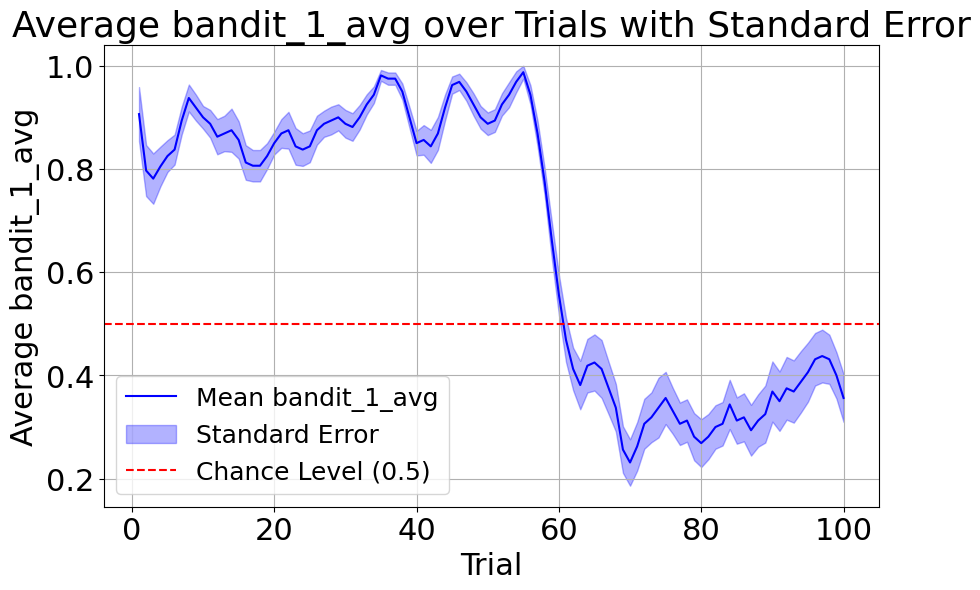

In [31]:
plot_bandit_1_avg(df_llama)

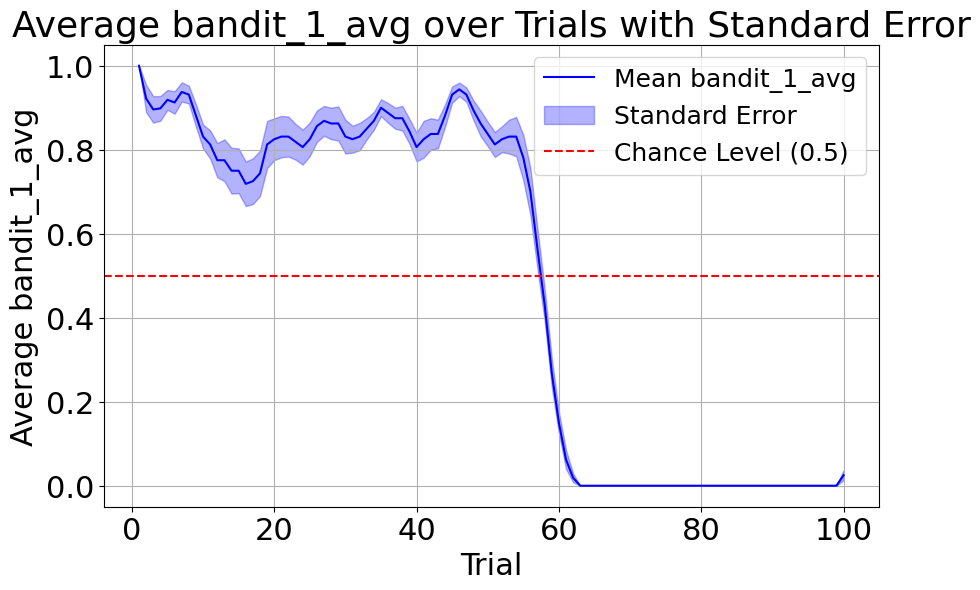

In [32]:
plot_bandit_1_avg(df_llama_3)

### Llama-70b

In [33]:
df_llama_70b=read_data_from_folder(f'{PATH}/llama-70B/singles')

32 CSV file(s) loaded.


In [34]:
df_llama_70b=bandit_1_prop(df_llama_70b,'U')

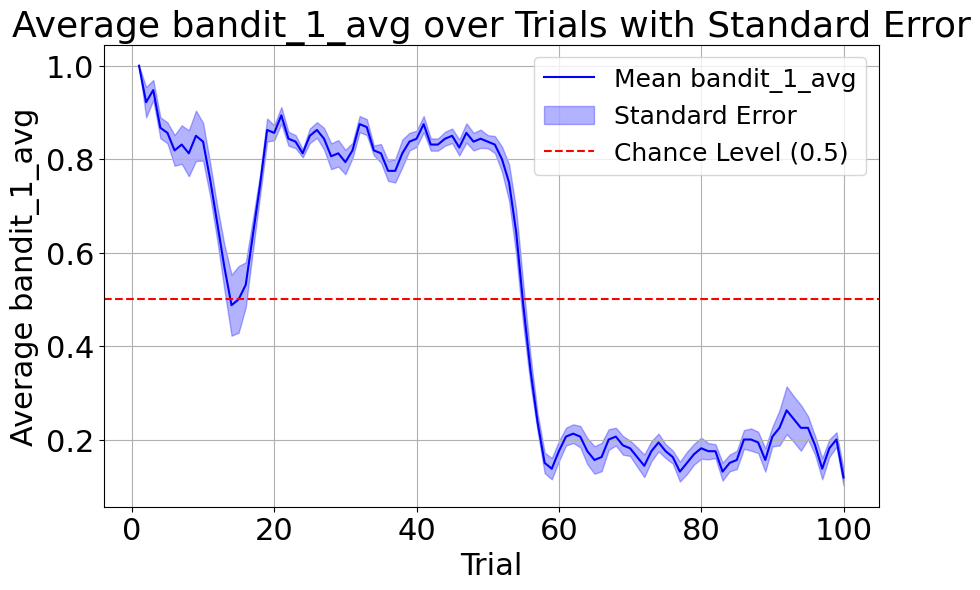

In [35]:
plot_bandit_1_avg(df_llama_70b)

### score vs trial

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_score_vs_trial(df, trial_col='trial_num', model_id_col='model_id', score_col='cumulative_reward',
                        figsize=(10, 6), title=None):
    """
    Plots average score vs trial across models with standard error margins.

    Parameters:
    df (pd.DataFrame): Input dataframe containing trial, model, and score data
    trial_col (str): Name of column containing trial numbers
    model_id_col (str): Name of column containing model identifiers
    score_col (str): Name of column containing scores
    figsize (tuple): Figure dimensions
    title (str): Custom plot title (optional)
    """
    # Group data and calculate statistics
    df_grouped = df.groupby([trial_col, model_id_col])[score_col].agg(['mean', 'sem']).reset_index()

    # Create plot
    plt.figure(figsize=figsize)

    # Plot each model's line with error bands
    for model_id in df_grouped[model_id_col].unique():
        model_data = df_grouped[df_grouped[model_id_col] == model_id]
        plt.plot(model_data[trial_col], model_data['mean'], label=model_id)
        plt.fill_between(model_data[trial_col],
                         model_data['mean'] - model_data['sem'],
                         model_data['mean'] + model_data['sem'],
                         alpha=0.2)

    # Add labels and legend
    default_title = f"{score_col} vs {trial_col} by {model_id_col} (Mean ± SEM)"
    plt.xlabel(trial_col)
    plt.ylabel(f'Average {score_col}')
    plt.title(title if title else default_title)
    plt.legend(title=model_id_col)
    plt.show()

# Example usage:


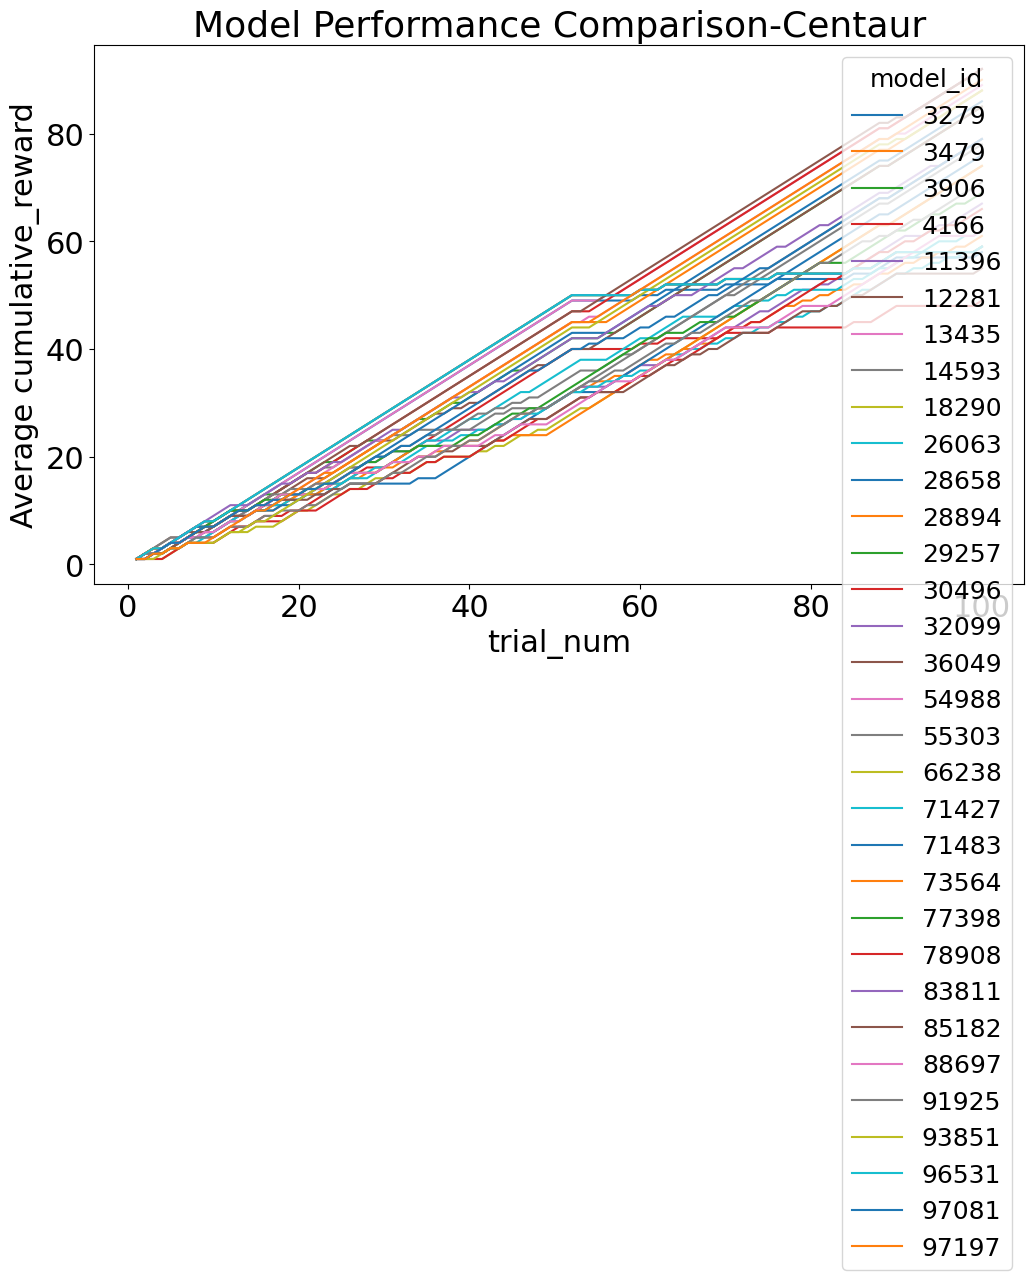

In [37]:
plot_score_vs_trial(df_centaur, figsize=(12, 7), title='Model Performance Comparison-Centaur')

In [38]:
plt.rcParams.update({
    'font.size': 22,        # everything (titles, labels, ticks, legend) gets bigger
    'axes.titlesize': 30,   # override just titles if you want
    'axes.labelsize': 28,   # axis labels
    'xtick.labelsize': 26,  # x-tick labels
    'ytick.labelsize': 28,  # y-tick labels
    'legend.fontsize': 22 #  # legend text
})

### Main Plot

In [39]:
df_rep.rename(columns={'trial': 'trial_num'}, inplace=True)

In [40]:
rw_df.rename(columns={'trial': 'trial_num'}, inplace=True)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_22136\3129917502.py:124: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


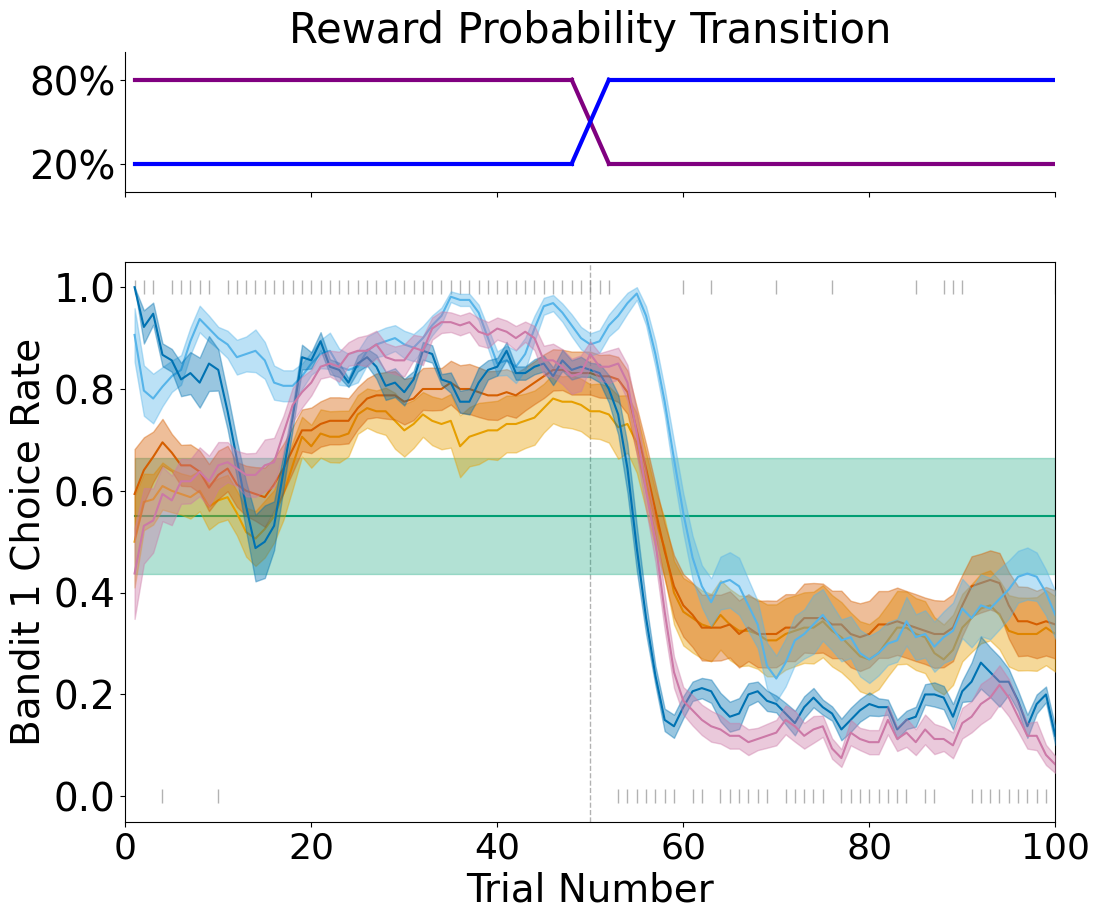

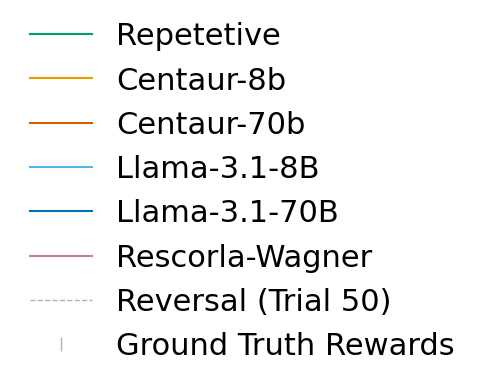

In [41]:
choice_rate_corrected,reversal_learning_legend=plot_bandit_choice_trends(
    human_df=None,
    df_rep=df_rep,
    dfs=[df_centaur,df_centaur_70b,df_llama,df_llama_70b,rw_df],
    labels=["Centaur-8b",'Centaur-70b','Llama-3.1-8B','Llama-3.1-70B','Rescorla-Wagner','Repetetive'],
    timeline=timeline,
    legend_anchor=(0.4, 0.45),
    reversal_trials=[50],
    colors=colors_grouped
)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_22136\3129917502.py:124: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


(<Figure size 1200x1000 with 2 Axes>, <Figure size 600x200 with 1 Axes>)

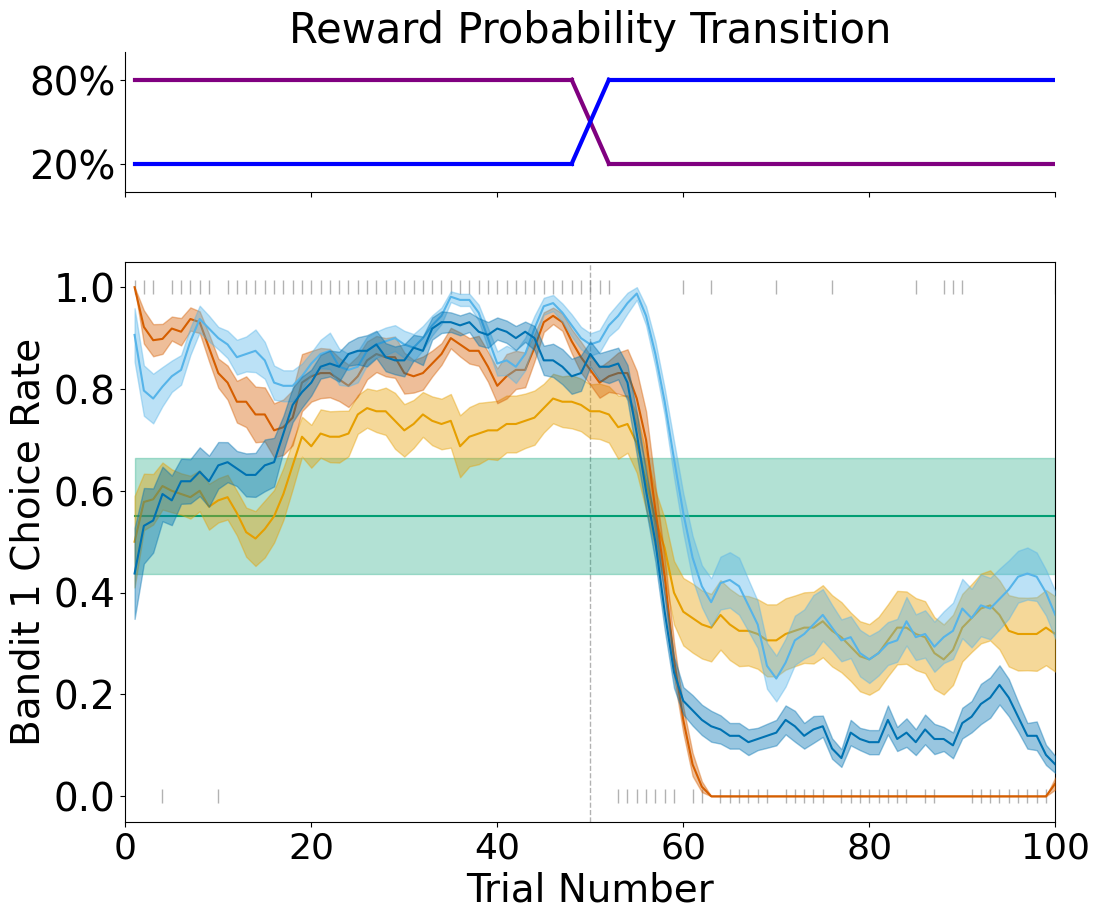

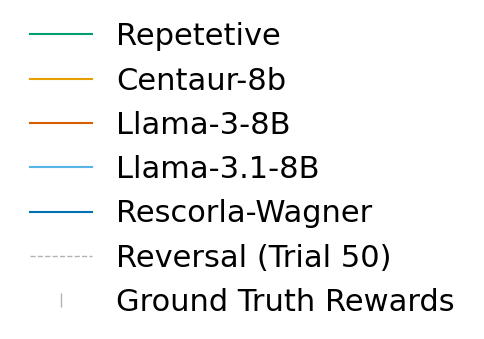

In [42]:
plot_bandit_choice_trends(
    human_df=None,
    df_rep=df_rep,
    dfs=[df_centaur,df_llama_3,df_llama,rw_df],
    labels=['Centaur-8b','Llama-3-8B','Llama-3.1-8B','Rescorla-Wagner','Repetetive'],
    timeline=timeline,
    legend_anchor=(0.4, 0.45),
    reversal_trials=[50],
    colors=colors_grouped
)

C:\Users\snamazova\AppData\Local\Temp\ipykernel_22136\1275704493.py:85: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


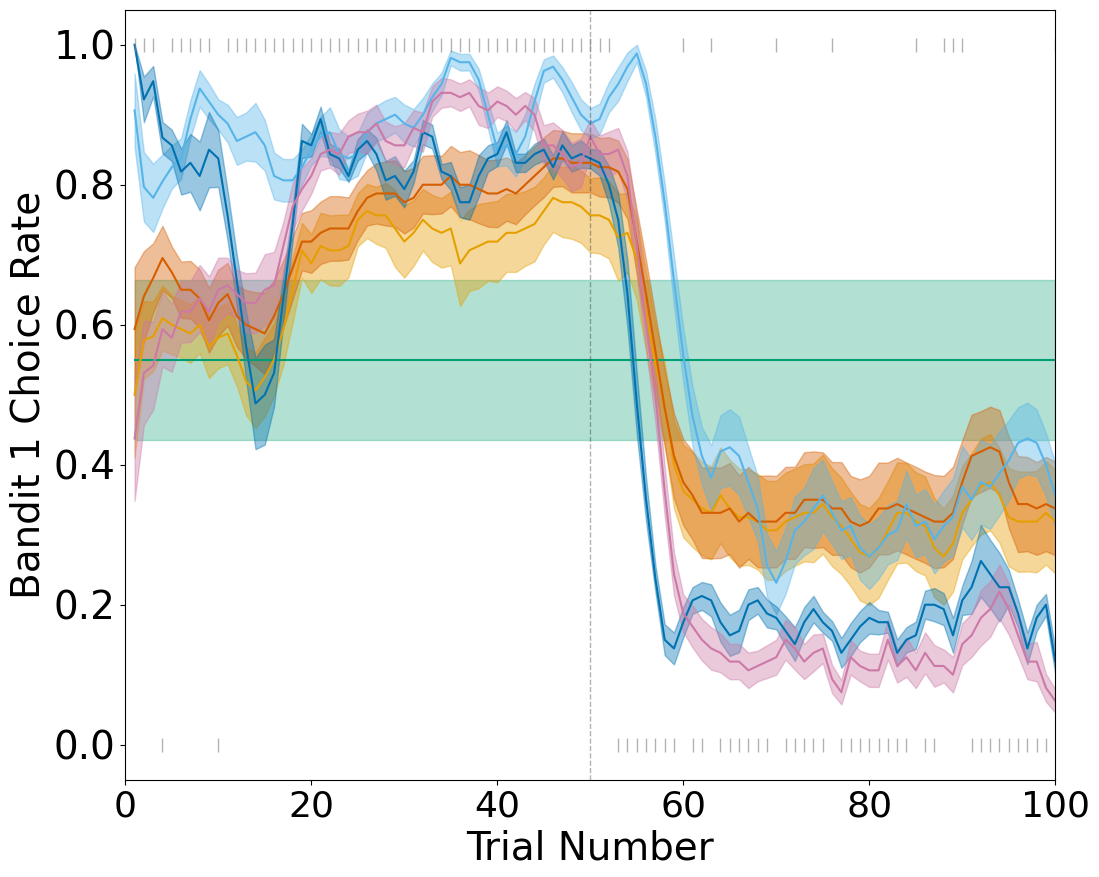

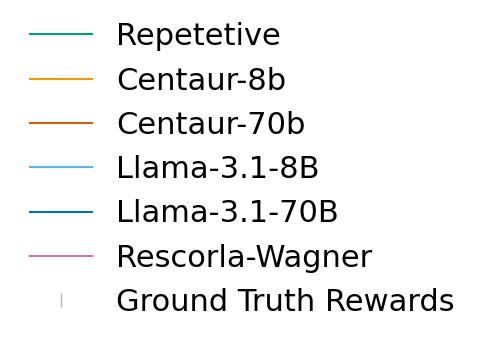

In [43]:
choice_rate_corrected,reversal_learning_legend=plot_bandit_choice_trends_single_axis(
    human_df=None,
    df_rep=df_rep,
    dfs=[df_centaur,df_centaur_70b,df_llama,df_llama_70b,rw_df],
    labels=["Centaur-8b",'Centaur-70b','Llama-3.1-8B','Llama-3.1-70B','Rescorla-Wagner','Repetetive'],
    timeline=timeline,
    legend_anchor=(0.4, 0.45),
    reversal_trials=[50],
    colors=colors_grouped
)

In [44]:
colors_large_models_only= ['black','#D55E00', '#0072B2', '#CC79A7','#009E73']

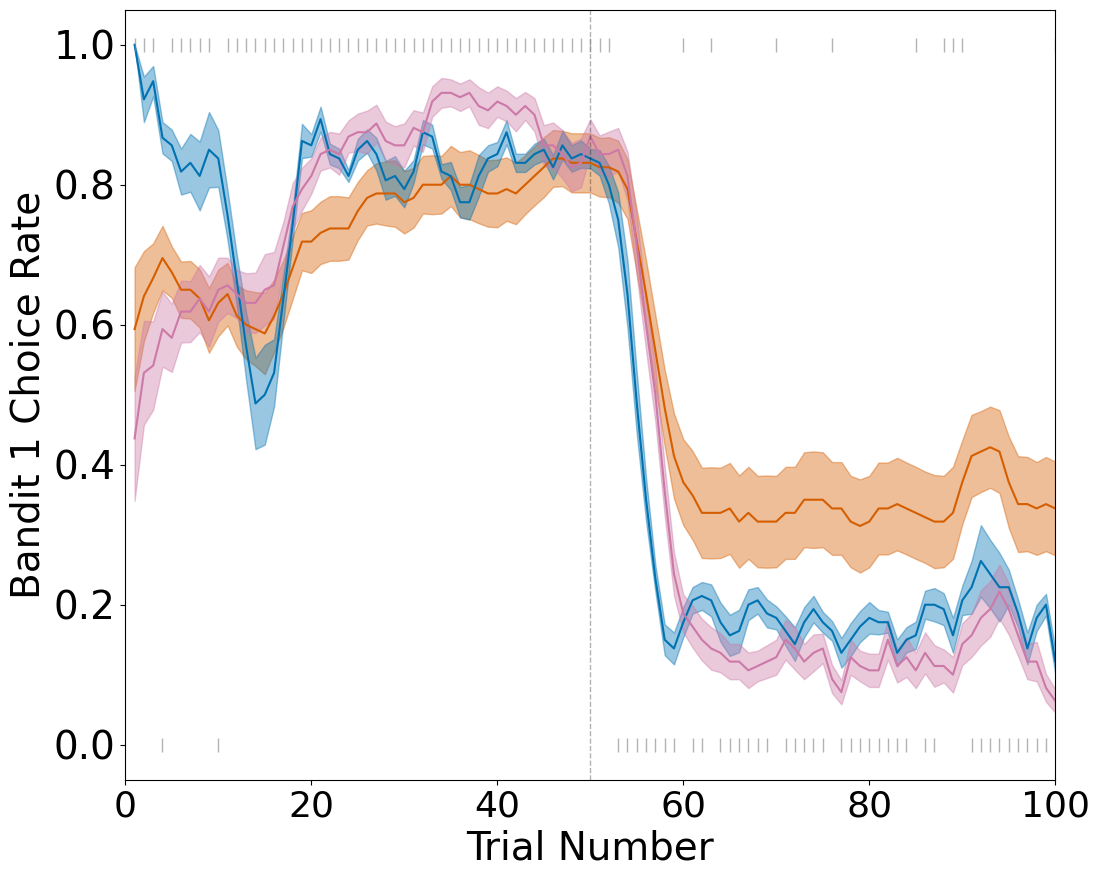

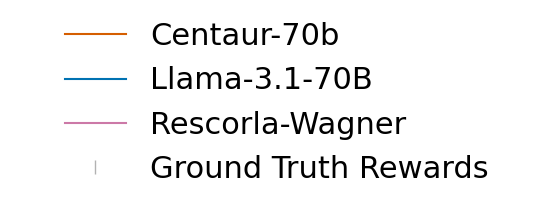

In [45]:
choice_rate_large_only,reversal_learning_legend=plot_bandit_choice_trends_single_axis(
    human_df=None,
    df_rep=None,
    dfs=[df_centaur_70b,df_llama_70b,rw_df],
    labels=['Centaur-70b','Llama-3.1-70B','Rescorla-Wagner','Repetetive'],
    timeline=timeline,
    legend_anchor=(0.4, 0.45),
    reversal_trials=[50],
    colors=colors_large_models_only
)

In [46]:
choice_rate_large_only.savefig('figures/choice_rate_large_only_70b.png', format='png', dpi=600, edgecolor='white', bbox_inches='tight', pad_inches=0.1)

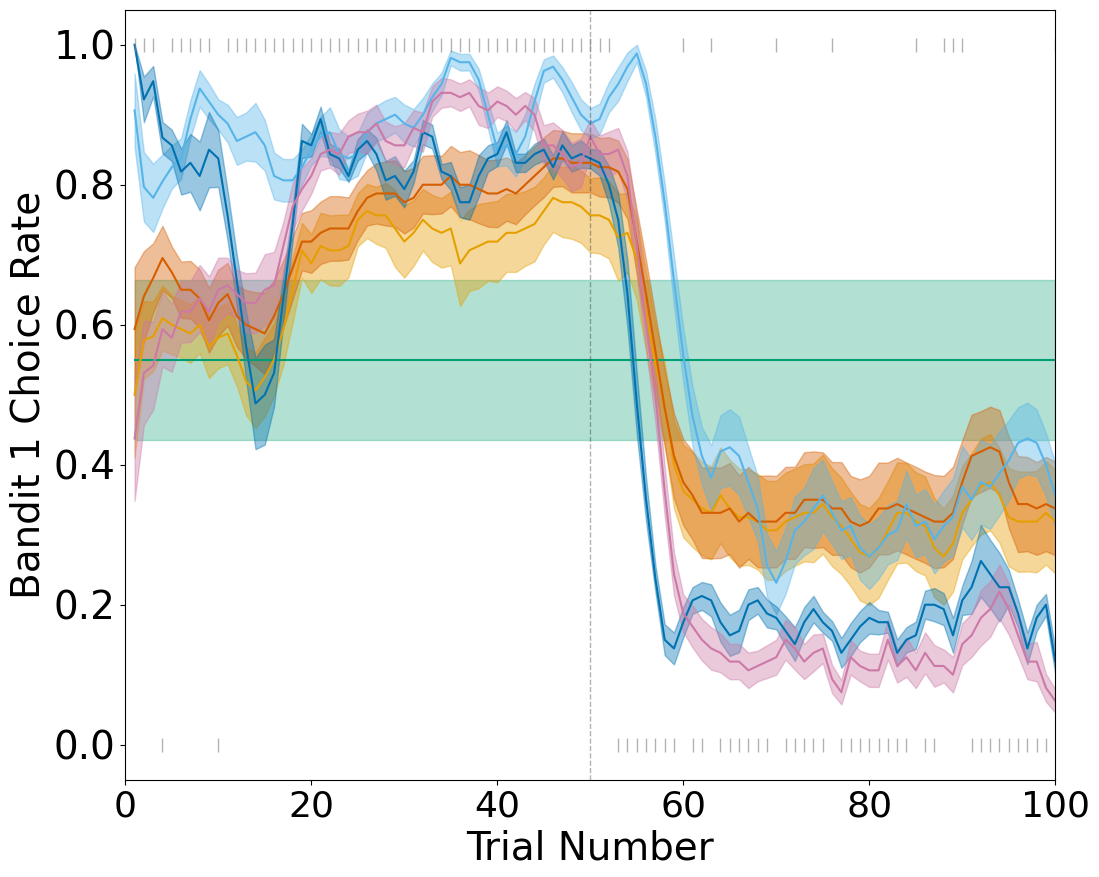

In [47]:
choice_rate_corrected

In [48]:
reversal_learning_legend.savefig('figures/reversal_learning_legend.png', format='png', dpi=600, edgecolor='white', bbox_inches='tight', pad_inches=0.1)

In [49]:
choice_rate_corrected.savefig('figures/choice_rate_main.pdf', format='pdf', dpi=600, edgecolor='white', bbox_inches='tight', pad_inches=0.1)

PermissionError: [Errno 13] Permission denied: 'figures/choice_rate_main.pdf'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.cm import get_cmap

def plot_bandit_choice_across_seeds(
    df=None, label=None, colormap='tab20b', trial_col="trial_num",
    bandit_avg_col="bandit_1_avg", reversal_trials=[14, 50],
    timeline=None, legend_anchor=(1.05, 1), xlim=(0, 100),
    title="Bandit 1 Choice Rates Across Seeds",
    margins=True, show_legend=True
):
    """
    Plots bandit 1 choice trends for each seed/model_id using perceptually distinct colors.
    """
    fig, ax_main = plt.subplots(figsize=(12, 10))
    # --- Model Data ---
    if df is not None and 'model_id' in df.columns:
        model_ids = df['model_id'].unique()
        cmap = get_cmap(colormap)
        color_shades = [cmap(i) for i in np.linspace(0, 1, len(model_ids))]

        for i, model_id in enumerate(model_ids):
            model_data = df[df['model_id'] == model_id]
            ax_main.plot(
                model_data[trial_col],
                model_data[bandit_avg_col],
                label=f'Seed {model_id}',
                color=color_shades[i],
                linestyle='-',
                linewidth=1.5,
                alpha=0.9,
                zorder=3
            )

    # --- Reversal Lines ---
    for reversal in reversal_trials:
        ax_main.axvline(x=reversal, color='black', linestyle='--', linewidth=1.0,
                        alpha=0.3, zorder=0)

    # --- Reward Ground Truth ---
    if timeline is not None:
        bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]
        ax_main.plot(
            range(1, len(bandit_1_rewards) + 1),
            bandit_1_rewards,
            color='gray',
            marker='|',
            linestyle='',
            markersize=10,
            alpha=0.6,
            label='Ground Truth Rewards'
        )

    ax_main.set_xlabel("Trial Number")
    ax_main.set_ylabel("Bandit 1 Choice Rate")
    #ax_main.set_title(title)
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(-0.05, 1.05)

    if show_legend:
        ax_main.legend(loc='upper left', bbox_to_anchor=legend_anchor)

    ax_main.grid(False)
    ax_prob.axis('off')
    plt.tight_layout()
    plt.show()

    return fig

C:\Users\snamazova\AppData\Local\Temp\ipykernel_12176\2522566315.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(colormap)


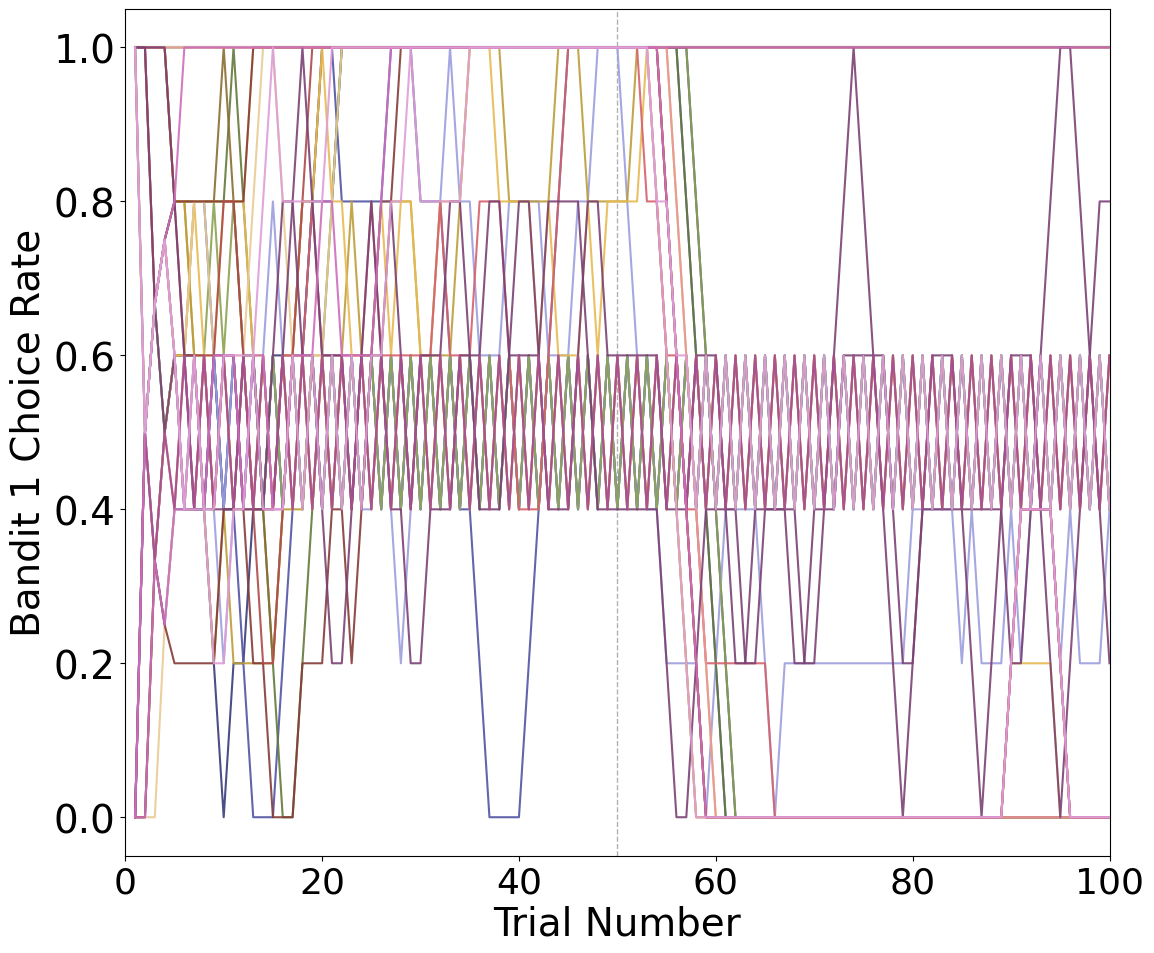

In [ ]:
choice_rate_seeds=plot_bandit_choice_across_seeds(
    df=df_centaur_70b,
    reversal_trials=[50],
    title="Variability In Bandit 1 Choice Rates Across Model Seeds",
    show_legend=False
)

In [ ]:
def plot_bandit_choice_across_selected_seeds(
    df=None, label=None, trial_col="trial_num",
    bandit_avg_col="bandit_1_avg", reversal_trials=[14, 50],
    timeline=None, legend_anchor=(1.05, 1), xlim=(0, 100),
    title="Bandit 1 Choice Rates Across Seeds",
    margins=True, show_legend=True,
    selected_model_ids=None,  # <-- New argument
            # Use 6 fixed, visually distinct colors
    color_shades = ['#1f77b4',  # blue
                        '#ff7f0e',  # orange
                        '#2ca02c',  # green
                        '#d62728',  # red
                        '#9467bd',  # purple
                        '#8c564b']  # brown

):
    """
    Plots bandit 1 choice trends for each seed/model_id using perceptually distinct colors.
    If selected_model_ids is provided, only those IDs will be plotted.
    """
    fig, ax_main = plt.subplots(figsize=(14, 10))

    # --- Model Data ---
    if df is not None and 'model_id' in df.columns:
        model_ids = df['model_id'].unique()

        if selected_model_ids is not None:
            model_ids = [mid for mid in model_ids if mid in selected_model_ids]

        color_shades = color_shades
        if len(model_ids) > len(color_shades):
            print("Warning: More than 6 models selected; colors will repeat.")


        for i, model_id in enumerate(model_ids):
                model_data = df[df['model_id'] == model_id]
                ax_main.plot(
                    model_data[trial_col],
                    model_data[bandit_avg_col],
                    label=f'Seed {model_id}',
                    color=color_shades[i % len(color_shades)],
                    linestyle='-',
                    linewidth=1.5,
                    alpha=0.9,
                    zorder=3
                )

    # --- Reversal Lines ---
    for reversal in reversal_trials:
        ax_main.axvline(x=reversal, color='black', linestyle='--', linewidth=1.0,
                        alpha=0.3, zorder=0)

    # --- Reward Ground Truth ---
    if timeline is not None:
        bandit_1_rewards = [trial["bandit_1"]["value"] for trial in timeline]
        ax_main.plot(
            range(1, len(bandit_1_rewards) + 1),
            bandit_1_rewards,
            color='gray',
            marker='|',
            linestyle='',
            markersize=10,
            alpha=0.6,
            label='Ground Truth Rewards'
        )

    ax_main.set_xlabel("Trial Number")
    ax_main.set_ylabel("Bandit 1 Choice Rate")
    ax_main.set_xlim(xlim)
    ax_main.set_ylim(-0.05, 1.05)

    if show_legend:
        ax_main.legend(loc='upper left', bbox_to_anchor=legend_anchor)

    ax_main.grid(False)
    plt.tight_layout()
    plt.show()

    return fig

In [ ]:
# prompt: from df_centaur_70b select 5 model ids that had the lowest cumulative reward

# Calculate cumulative reward for each model_id
cumulative_rewards = df_centaur_70b.groupby('model_id')['cumulative_reward'].max()

# Sort model_ids by cumulative reward in ascending order and get the top 5
lowest_reward_model_ids = cumulative_rewards.sort_values(ascending=True).head(5).index.tolist()

print("Model IDs with the lowest cumulative reward:")
lowest_reward_model_ids


Model IDs with the lowest cumulative reward:


[71427, 3279, 32099, 18290, 96531]

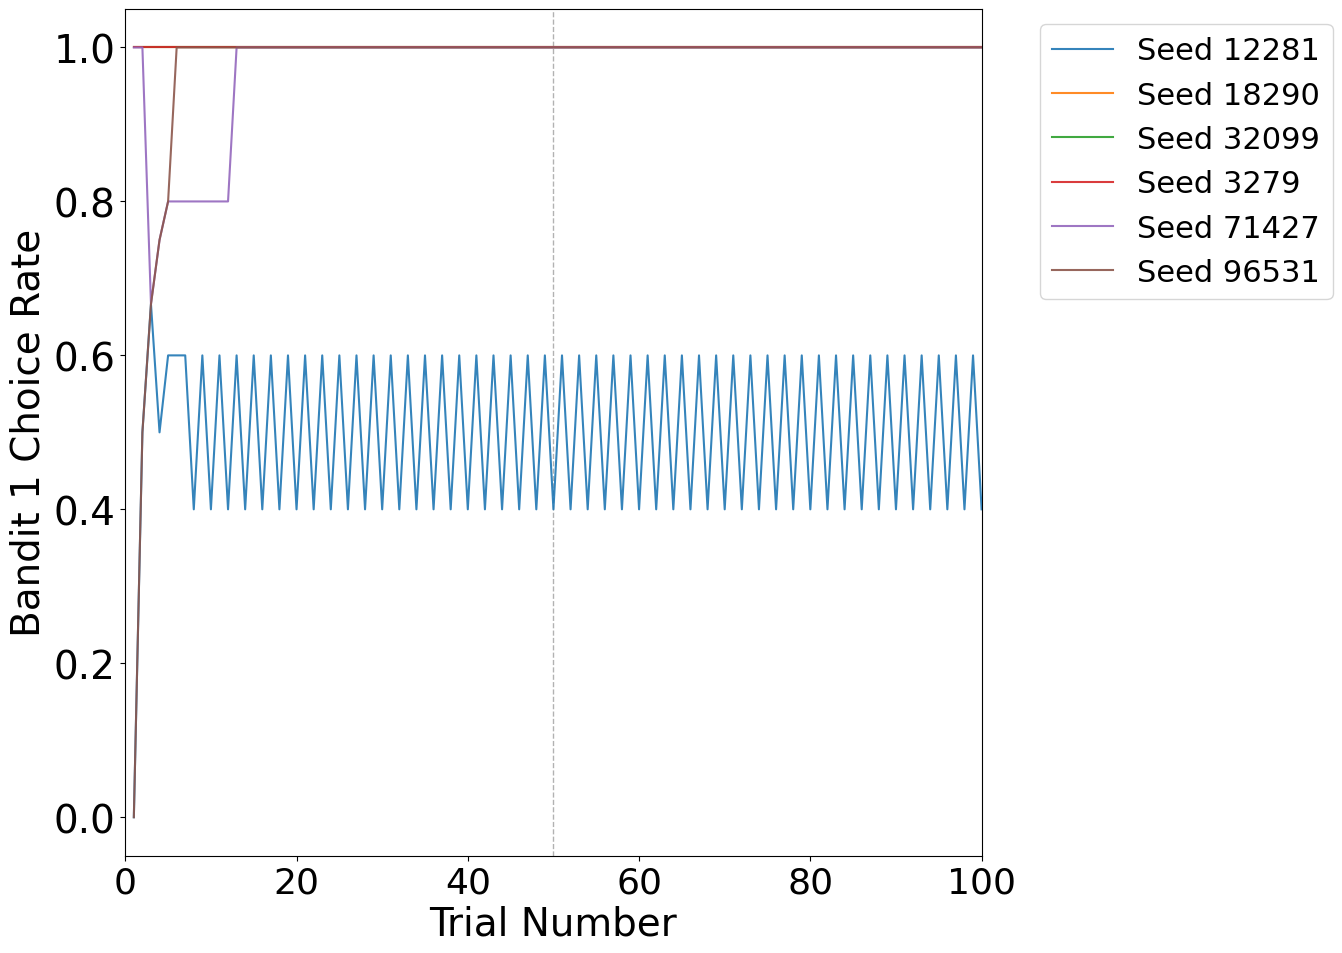

In [ ]:
# List of model_ids (seeds) you want to plot
selected_ids = [26063,12281,28894,4166]  # for example
lowest_reward_model_ids.append(12281)
choice_rate_selected_seeds=plot_bandit_choice_across_selected_seeds(
    df=df_centaur_70b,
    reversal_trials=[50],
    title="Variability In Bandit 1 Choice Rates Across Model Seeds",
    show_legend=True,
    selected_model_ids=lowest_reward_model_ids
)

In [ ]:
choice_rate_selected_seeds.savefig('figures/choice_rate_selected_seeds.pdf', format='pdf', dpi=600, edgecolor='white', bbox_inches='tight', pad_inches=0.1)

In [ ]:
df_centaur_70b[df_centaur_70b['model_id']==12281]

,trial_num,prompt,choice,reward,cumulative_reward,model_id,bandit1_chosen,bandit_1_avg
100,1,"In this task, you have to repeatedly choose be...",P,1,1,12281,0,0.000000
101,2,"In this task, you have to repeatedly choose be...",U,1,2,12281,1,0.500000
102,3,"In this task, you have to repeatedly choose be...",U,1,3,12281,1,0.666667
103,4,"In this task, you have to repeatedly choose be...",P,1,4,12281,0,0.500000
104,5,"In this task, you have to repeatedly choose be...",U,1,5,12281,1,0.600000
...,...,...,...,...,...,...,...,...
195,96,"In this task, you have to repeatedly choose be...",P,1,59,12281,0,0.400000
196,97,"In this task, you have to repeatedly choose be...",U,0,59,12281,1,0.600000
197,98,"In this task, you have to repeatedly choose be...",P,1,60,12281,0,0.400000
198,99,"In this task, you have to repeatedly choose be...",U,0,60,12281,1,0.600000


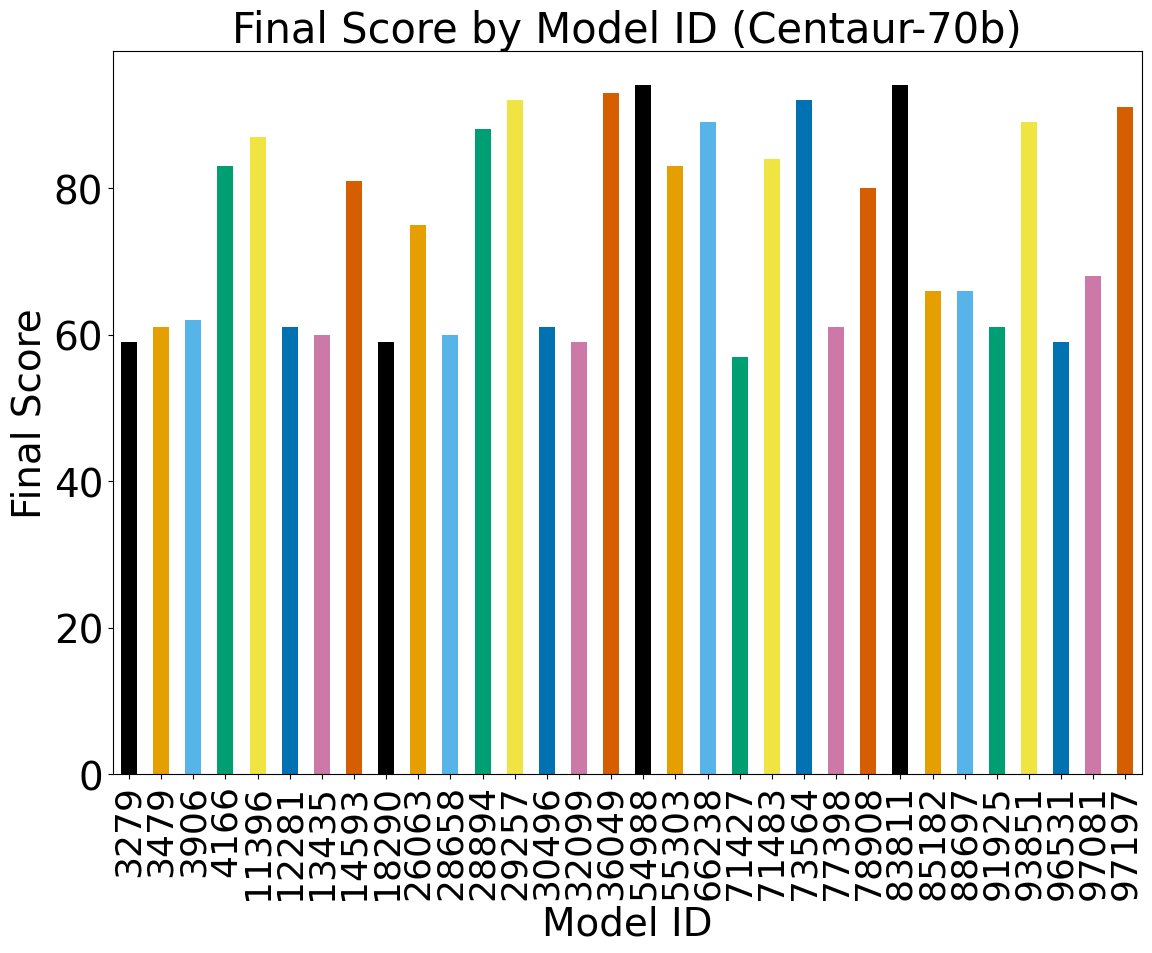

In [ ]:
# prompt: plot final score of each model id in df_Centaur_70b as bar plot,

import matplotlib.pyplot as plt
# Plot final score of each model_id in df_Centaur_70b as a bar plot
plt.figure(figsize=(12, 10))
cumulative_rewards.plot(kind='bar', color=colors)
plt.title('Final Score by Model ID (Centaur-70b)')
plt.xlabel('Model ID')
plt.ylabel('Final Score')
#plt.xticks(rotation=45, ha='right') # Rotate labels for readability
plt.tight_layout()
plt.show()
